In [0]:
pip install kmodes

In [0]:
# Standard IPython notebook imports
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import scipy.stats as sstats
import scipy.linalg as slinalg
import math
from kmodes.kmodes import KModes
from skimage import io
from time import time
import tqdm

import seaborn as sns
from sklearn import datasets

#Zadanie 0. (2 punkty)

Zaimplementuj algorytm K-Means. Postaraj się, żeby implementacja była efektywna, bo będzie on w przyszłości używany do przetwarzania dużych zbiorów danych. Sprawdź działanie
zaimplementowanego algorytmu na danych IRIS.

##Algorytm k-means

Niech D = {x1, x2, …, xN} będzie zbiorem danych złożonym z N obserwacji x1, x2,…, xN. Niech K będzie liczbą grup, które należyutworzyć.
Każda grupa Ck reprezentowana jest przez punkt rk zwany centrum grupy. Każdy wektor danych jest przypisywany do grupy, której centrum jest mu najbliższe.W przypadku równych odległości od kilku centrów, decyduje ustalona kolejność rozpatrywania grup lub przypisanie jest losowe

Zadanie polega na znalezieniu K elementowej partycji C = {C1, C2, …,CK} zbioru D (tzn. K parami rozłącznych zbiorów C1, C2, …, CK takich, że C1 ∪ C2 ∪ … ∪ CK = D) minimalizującej funkcję kryterium.

Jednym z algorytmów rozwiązujących taki problem jest algorytm kmeans.

    FOR k = 1, 2, …, K
        r_k = losowo wybrany punkt z D
    WHILE są zmiany w grupach Ck
        FOR k = 1, 2, …, K
            Ck = {x∈D : d(x, rk) < d(x, rl) dla każdego l = 1, 2, …, K, l ≠ k}
        FOR k = 1, 2, …, K
            r_k = środek ciężkości Ck

In [0]:
def dists_matrix(X,Y):
    # X = [[v11,v21,v31,...,vn1], 
    #      [v12,v22,v32,...,vn2],
    #      ...
    #      [v1k,v2k,v3k,...,vnk]]
    # Y = [[u11,u21,u31,...,um1], 
    #      [u12,u22,u32,...,um2],
    #      ...
    #      [u1k,u2k,u3k,...,umk]]
    # res = [[dist(v1,u1),dist(v2,u1),dist(v3,u1),...,dist(vn,u1)],
    #        [dist(v1,u2),dist(v2,u2),dist(v3,u2),...,dist(vn,u2)],
    #        [dist(v1,u3),dist(v2,u3),dist(v3,u3),...,dist(vn,u3)],
    #        ...
    #        [dist(v1,um),dist(v2,um),dist(v3,um),...,dist(vn,um)]]
    # dist = sum((vni - umi)**2), for i = 0 to k
    return -2 * np.dot(Y.T, X) + np.sum(Y.T**2, axis=1)[:, np.newaxis]

In [0]:
def K_means(data,K,iters=300,debug=False):
    # data - matrix of vectors
    # K - # groups
    # result - C = 1xN, where C[i] = j <=> j`th vector is member of i`th group,R = centers of groups
    d,N = data.shape

    R = data[:,np.random.choice(N,K)]
    if debug:
        print("R randomly choosed")
    changed = True
    C = np.zeros(N)
    while changed and iters > 0:
        iters -= 1
        changed = False

        dists = dists_matrix(data,R)
        if debug:
            print(f"Iter to end {iters} dists calculed")
        new_C = np.argmin(dists,0)
        if np.any(new_C != C):
            changed = True
            if debug:
                print(f"C has been changed")
        C = new_C

        S = np.zeros([d,K])
        J = np.full(K,1e-100)
        for i in range(N):
            S[:,C[i]] += data[:,i]
            J[C[i]] += 1
        S /= J
        if debug:
            print(f"Iter to end {iters}, R calculed")
        if not changed and np.any(R != S):
            changed = True
            if debug:
                print(f"R has been changed")
        R = S

    return C,R
        

In [0]:
def normalize(labels,K):
    N = len(labels)
    d = {}
    j = 0
 
    for i in range(K):
        x = round(np.mean(labels[i*(N//K):(i+1)*(N//K)]))
        if x in d:
            x = math.floor(np.mean(labels[i*(N//K):(i+1)*(N//K)]))
            if x in d:
                x - math.ceil(np.mean(labels[i*(N//K):(i+1)*(N//K)]))

        d[x] = i
    normalized_labels = np.copy(labels)

    for i in range(len(normalized_labels)):
        normalized_labels[i] = d[normalized_labels[i]]
    return normalized_labels

In [0]:
iris = datasets.load_iris() 
labels,centers = K_means(iris.data.T,3)
edge_labels = np.array(["Green" if normalize(labels,3)[i] == iris.target[i] else "Red" for i in range(len(labels))])
plt.scatter(iris.data[:,:1].ravel(),iris.data[:,1:2].ravel(),c=labels,edgecolor = edge_labels)
plt.scatter(centers[:1,:].ravel(),centers[1:2,:].ravel(),c=[0,1,2],marker='^',edgecolors="Black")
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Iris')
plt.show

KeyError: ignored

In [0]:
plt.scatter(iris.data[:,2:3].ravel(),iris.data[:,3:].ravel(),c=labels,edgecolor = edge_labels)
plt.scatter(centers[2:3,:].ravel(),centers[3:,:].ravel(),c=[0,1,2],marker='^',edgecolors="Black")
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('Iris')
plt.show


#Zadanie 1. (1 punkt)

Napisz program, który generuje zbiór N = 5000 losowych wektorów danych z mieszaniny rozkładów gaussowskich o niżej podanych parametrach i sprawdź działanie algorytmu K-Means na tym zbiorze (rozkład Choleskiego macierzy kowariancji można w Matlabie uzyskać poleceniem chol, a w Pythonie poleceniem cholesky).


In [0]:
def generate_gaussian_mixture(d,K,p,mu,s,N = 5000):
    X = np.random.randn(d,N)
    groups = np.random.choice(K, N, p=p)
    S = np.array([slinalg.cholesky(si) for si in s])
    for i in range(N):
        X[:,i] = np.dot(S[groups[i]],X[:,i]) + mu[groups[i]]
    return X


In [0]:
def plot(X,labels,centers,K,d,x = 0,y = 1):
    plt.scatter(X[x:x+1,:].ravel(),X[y:y+1,:].ravel(),c=labels,edgecolor = "Black")
    plt.scatter(centers[x:x+1,:].ravel(),centers[y:y+1,:].ravel(),c=np.arange(K),marker='^',edgecolors="Black")
    plt.xlabel(f'x{x}')
    plt.ylabel(f'x{y}')
    plt.title(f'K-mean, K = {K}, d = {d}')
    plt.show

##a) d = 2, K = 5, p = 1/K * 1, µk = 3k * 1, Σk = I (dla k = 1, 2, …, K),

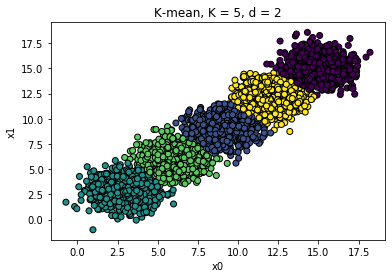

In [0]:
d = 2
K = 5
p = 1/K * np.ones(K)
mu = np.array([ 3*k*np.ones(d) for k in range(1,K+1)])
s = np.array([np.eye(d) for k in range(K)])
X = generate_gaussian_mixture(d,K,p,mu,s)
G,R = K_means(X,K)
plot(X,G,R,K,d)

##b) jak w a), oprócz Σ3 = [3 0; 0 1],

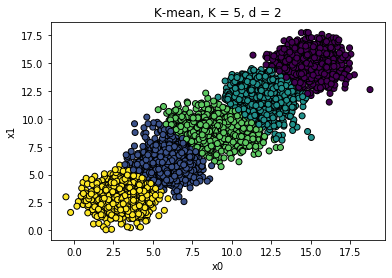

In [0]:
d = 2
K = 5
p = 1/K * np.ones(K)
mu = np.array([ 3*k*np.ones(d) for k in range(1,K+1)])
s = np.array([np.eye(d) for k in range(K)])
s[2] = np.array([[3,0],[0,1]])
X = generate_gaussian_mixture(d,K,p,mu,s)
G,R = K_means(X,K)
plot(X,G,R,K,d)

##c) jak w b), oprócz Σ1 = [3 1; 1 1],

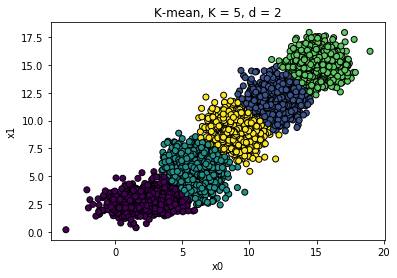

In [0]:
d = 2
K = 5
p = 1/K * np.ones(K)
mu = np.array([ 3*k*np.ones(d) for k in range(1,K+1)])
s = np.array([np.eye(d) for k in range(K)])
s[0] = np.array([[3,1],[1,1]])
X = generate_gaussian_mixture(d,K,p,mu,s)
G,R = K_means(X,K)
plot(X,G,R,K,d)

##d) jak w c), oprócz p = [0.2; 0.1; 0.3; 0.1; 0.3],

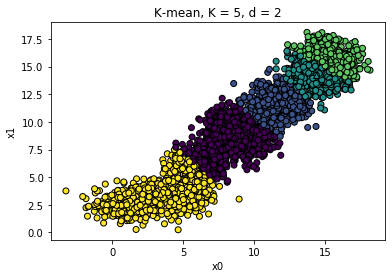

In [0]:
d = 2
K = 5
p = np.array([0.2, 0.1, 0.3, 0.1, 0.3])
mu = np.array([ 3*k*np.ones(d) for k in range(1,K+1)])
s = np.array([np.eye(d) for k in range(K)])
s[0] = np.array([[3,1],[1,1]])
X = generate_gaussian_mixture(d,K,p,mu,s)
G,R = K_means(X,K)
plot(X,G,R,K,d)

##e) jak w a), oprócz d = 3 i Σ3 = [3 1 0; 1 1 0; 0 0 1],

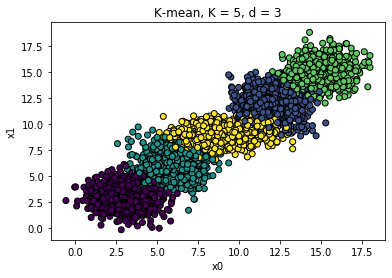

In [0]:
d = 3
K = 5
p = 1/K * np.ones(K)
mu = np.array([ 3*k*np.ones(d) for k in range(1,K+1)])
s = np.array([np.eye(d) for k in range(K)])
s[2] = np.array([[3, 1, 0],[1, 1, 0],[0,0,1]])
X = generate_gaussian_mixture(d,K,p,mu,s)
G,R = K_means(X,K)
plot(X,G,R,K,d)

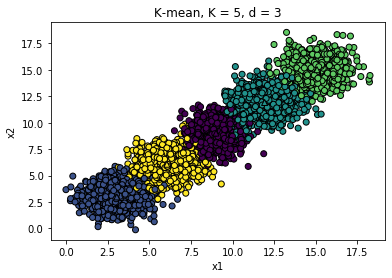

In [0]:
plot(X,G,R,K,d,1,2)

##f) jak w a), oprócz d = 100 i K = 10.

(1 to wektor odpowiedniej długości złożony z samych jedynek, I to macierz identycznościowa).
Jak pogrupowałbyś te dane, jeśli nie znałbyś wartości K użytej w generatorze? 

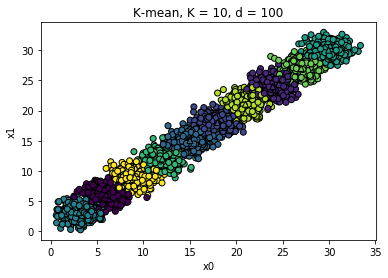

In [0]:
d = 100
K = 10
p = 1/K * np.ones(K)
mu = np.array([ 3*k*np.ones(d) for k in range(1,K+1)])
s = np.array([np.eye(d) for k in range(K)])
X = generate_gaussian_mixture(d,K,p,mu,s)
G,R = K_means(X,K)
plot(X,G,R,K,d)

#Zadanie 2. (1 punkt)
Wygeneruj zbiór N = 1000000 losowych danych z d = 1000 wymiarowej mieszaniny K = 1000 rozkładów gaussowskich takiej, że odległość między środkami µk każdych dwóch rozkładów tej mieszaniny jest nie mniejsza niż q = 10. Prawdopodobieństwa wyboru rozkładów mogą być równe, p = 1/K * 1, a same rozkłady mogą mieć nieskorelowane zmienne, Σk = I. Sprawdź działanie algorytmu K-Means na tym zbiorze. Poeksperymentuj z innymi wartościami parametru q. 


In [0]:
x = np.array([[1,2,3,5],[5,4,5,6]])
y = np.array([[0,2],[1,3]])
np.apply_along_axis(lambda e: np.mean(x[:,e],1),1,y).T

array([[2. , 3.5],
       [5. , 5. ]])

In [0]:
def generate_gaussian_mixture_2(d,K,q=10,N = 5000):
    X = np.random.randn(d,N)
    groups = np.random.choice(K, N)
    X += q * groups
    return X

In [0]:
d = 1000
K = 1000
X = generate_gaussian_mixture_2(d,K,100,10000)
print("Generated")


Generated


R randomly choosed
Iter to end 9 dists calculed
C has been changed
Iter to end 9, R calculed
Iter to end 8 dists calculed
C has been changed
Iter to end 8, R calculed
Iter to end 7 dists calculed
C has been changed
Iter to end 7, R calculed
Iter to end 6 dists calculed
C has been changed
Iter to end 6, R calculed
Iter to end 5 dists calculed
Iter to end 5, R calculed
done


<function matplotlib.pyplot.show>

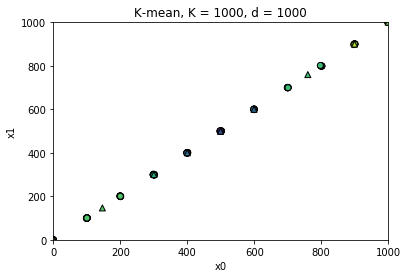

In [0]:
G,R = K_means(X,K,10,True)
print("done")
plot(X,G,R,K,d)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.show

#Zadanie 3. (2 punkty)
W UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/) można znaleźć przykładowe dane do testowania działania algorytmów eksploracji danych. Pobierz 5 zestawów danych (Iris, Wine oraz 3 inne wybrane przez siebie). Zapoznaj się z opisem tych danych. Spróbuj opisać charakterystykę tych danych. Spróbuj przedstawić te dane na wykresach. Sprawdź jak dobrze można je pogrupować za pomocą znanych Ci algorytmów grupowania (sprawdź co najmniej KMeans). 


##1. Iris 
- zbiór 150 danych dotyczących kwiatów. Dane mają 4 atrybuty i 3 grupy, wszystkie z nich są numeryczne (float). W tym zbiorze nie ma nieznanych wartości atrybutów. Działanie Kmean mocno zależy od wylosowania początkowych środków. Kmean nie ma problemu z oddzieleniem iris_setosa od pozostałych, ale popełnia dużo błędów w rozdzieleniu 2 pozostałych grup.

<function matplotlib.pyplot.show>

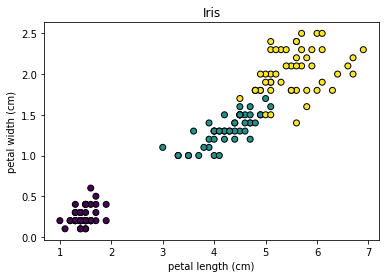

In [0]:
iris = datasets.load_iris() 
plt.scatter(iris.data[:,2:3].ravel(),iris.data[:,3:4].ravel(),c=iris.target,edgecolor = "Black")
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('Iris')
plt.show

##2. Wine
 - dane dotyczących rodzai win, 13 atrybutów, 3 grupy. Wszystkie atrybuty są numeryczne (int, float). Dane mają więcej wymiarów, niż Iris, więc ciężej je przedstawić na wykresach, patrząc na pierwszy i ostatni wymiar możemy zauważyć, że K-means popełnia błędy, ale mimo to całkiem dobrze grupuje te dane.

In [0]:
wine = datasets.load_wine()

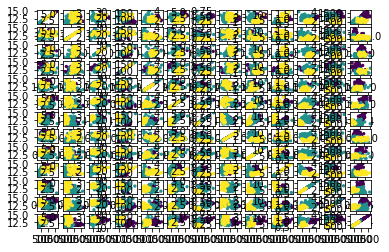

In [0]:
fig, axs = plt.subplots(13, 13)
for i in range(13):
    for j in range(13):
        axs[i,j].scatter(wine.data[:,i:i+1].ravel(),wine.data[:,j:j+1].ravel(),c=wine.target,s=5)

<function matplotlib.pyplot.show>

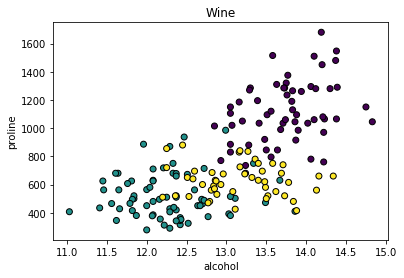

In [0]:
plt.scatter(wine.data[:,0:1].ravel(),wine.data[:,12:13].ravel(),c=wine.target,edgecolor = "Black")
plt.xlabel('alcohol')
plt.ylabel('proline')
plt.title('Wine')
plt.show

<function matplotlib.pyplot.show>

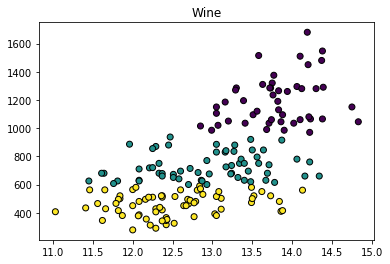

In [0]:
labels,centers = K_means(wine.data.T,3)
plt.scatter(wine.data[:,0:1].ravel(),wine.data[:,12:13].ravel(),c=labels,edgecolor = "Black")
plt.title('Wine')
plt.show

<function matplotlib.pyplot.show>

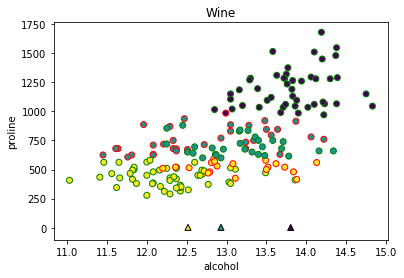

In [0]:
edge_labels = np.array(["Green" if normalize(labels,3)[i] == wine.target[i] else "Red" for i in range(len(labels))])
plt.scatter(wine.data[:,0:1].ravel(),wine.data[:,12:13].ravel(),c=labels,edgecolor = edge_labels)
plt.scatter(centers[:1,:].ravel(),centers[1:2,:].ravel(),c=[0,1,2],marker='^',edgecolors="Black")
plt.xlabel('alcohol')
plt.ylabel('proline')
plt.title('Wine')
plt.show

<function matplotlib.pyplot.show>

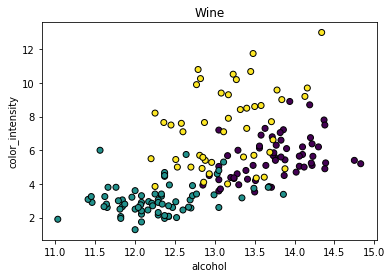

In [0]:
l,r = K_means(wine.data.T,3)
plt.scatter(wine.data[:,0:1].ravel(),wine.data[:,9:10].ravel(),c=wine.target,edgecolor = "Black")
plt.xlabel('alcohol')
plt.ylabel('color_intensity')
plt.title('Wine')
plt.show

##3. Mashroom 
- 8124 danych, 22 atrybutów, 2 grupy. Niektóre przykłady nie mają informacji o wszystkich atrybutach. Atrybuty są kategoryczne, więc algorytm Kmean nie będzie na nich działał. Należy wykorzystać algorytm Kmodes. Na tych danych można wyszkolić drzewa decyzyjne, które szczególnie po ich uproszczeniu działaja bardzo dobrze. Można więc budować również random forest. O danych najwięcej mówi kolumna 'odor', pozwala ona ze stosunkowo małym błędem rozróżnić dane już w pierwszym kroku. 

In [0]:
columns = [
 "target", "cap-shape", "cap-surface", "cap-color", "bruises?", "odor", 
 "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape", 
 "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
 "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", 
 "ring-number", "ring-type", "spore-print-color", "population", "habitat", ]

# Use read_csv to load the data.
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
mushroom_df = pd.read_csv(url, header=None, names=columns)
mushroom_idx_df = mushroom_df.reset_index()

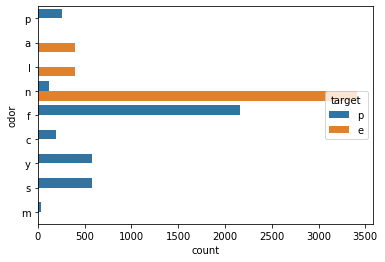

In [0]:
sns.countplot(y = 'odor', data = mushroom_df, hue = 'target')

In [0]:
km = KModes(n_clusters=2, init='random', n_init=5)
labels = km.fit_predict(mushroom_df)

In [0]:
1 - sum(labels == [1 if e == "e" else 0 for e in mushroom_df.target]) / len(labels)

0.8993106843919252

##4. German credits
 - dane odnośnie kredytów, 1000 danych po 20 atrybutów, 2 grupy (70% danych to grupa 1). Atrybuty są zarówno kategoryczne, jak i liczbowe. Dane są trudne do klasyfikacji, drzewo decyzyjne myli się średnio w co 3 danej testowej. Ograniczając się do kolumn A2 (okres kredytu), A5 (kwota kredytu), A8 (stopa raty jako procent dochodu), A13 (wiek), A16 (liczba kredytów w tym banku), A18 (liczba osób odpowiedzialnych za utrzymanie) można spróbować klasyfikować te dane za pomocą KMean.

In [0]:
german_df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
    names=[f'A{d}' for d in range(1,21)] + ['target'], header=None, sep=' ')

In [0]:
german_integral = np.array([german_df.A2,german_df.A5,german_df.A8,german_df.A13,german_df.A16,german_df.A16,german_df.A18])
german_target = np.array(german_df.target)

0.671


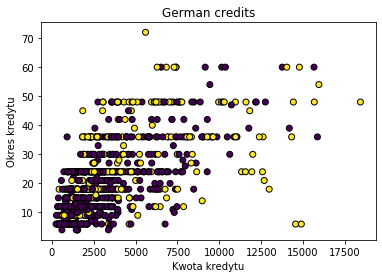

In [0]:
l,r = K_means(german_integral,2)
#edge_labels = np.array(["Green" if l[i] + 1 == german_target[i] else "Red" for i in range(len(l))])
plt.scatter(german_integral[1:2].ravel(),german_integral[0:1].ravel(),c=german_target,edgecolor = "Black")
plt.xlabel('Kwota kredytu')
plt.ylabel('Okres kredytu')
plt.title('German credits')
plt.show

print(1 - sum([l[i] + 1 == german_target[i]for i in range(len(l))]) / len(l) )

In [0]:
labels = km.fit_predict(german_df)

In [0]:
1 - sum(labels+1 == german_df.target)/1000

0.473

<function matplotlib.pyplot.show>

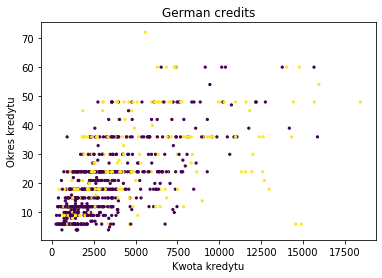

In [0]:
plt.scatter(german_integral[1:2].ravel(),german_integral[0:1].ravel(),c=german_target,s=5)
plt.xlabel('Kwota kredytu')
plt.ylabel('Okres kredytu')
plt.title('German credits')
plt.show

<function matplotlib.pyplot.show>

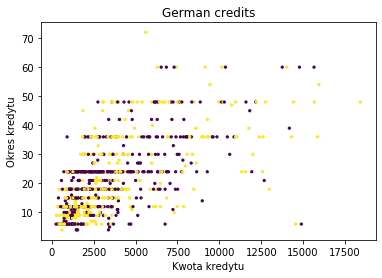

In [0]:
plt.scatter(german_integral[1:2].ravel(),german_integral[0:1].ravel(),c=labels,s=5)
plt.xlabel('Kwota kredytu')
plt.ylabel('Okres kredytu')
plt.title('German credits')
plt.show

'\nAttribute 17: (qualitative)\nJob\nA171 : unemployed/ unskilled - non-resident\nA172 : unskilled - resident\nA173 : skilled employee / official\nA174 : management/ self-employed/highly qualified employee/ officer\n'

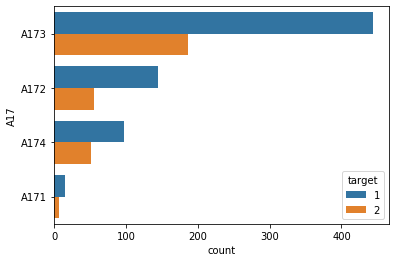

In [0]:
sns.countplot(y = 'A17', data = german_df, hue = 'target')
'''
Attribute 17: (qualitative)
Job
A171 : unemployed/ unskilled - non-resident
A172 : unskilled - resident
A173 : skilled employee / official
A174 : management/ self-employed/highly qualified employee/ officer
'''

##5. Vote
- zbiór danych składa się z 435 danych (kongresmenów USA) oraz 16 atrybutów (najważniejszych głosowań), kongresmeni są podzieleni na 2 grupy (republikanie oraz demokraci). Atrybuty są binarne (odpowiedzi tak/nie), niektórzy kongresmeni nie odpowiedzieli na niektóre pytania, ale w przypadku tego zbioru taką odpowiedź nie tratujemy jako "missing-values", ale jako jedną z 3 możliwych odpowiedzi (tak / nie / wstrzymuję się od głosu). Danych nie można sklasyfikować KMean (brak liczb), można na nich wyszkolić dosyć dokładne drzewo decyzyjne.


In [0]:
columns = ['target','handicapped-infants', 'water-project-cost-sharing',
       'adoption-of-the-budget-resolution', 'physician-fee-freeze',
       'el-salvador-aid', 'religious-groups-in-schools',
       'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
       'immigration', 'synfuels-corporation-cutback', 'education-spending',
       'superfund-right-to-sue', 'crime', 'duty-free-exports',
       'export-administration-act-south-africa']
vote_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header=None,
                       names = columns)

In [0]:
vote_df

,target,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,republican,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
431,democrat,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
432,republican,n,?,n,y,y,y,n,n,n,n,y,y,y,y,n,y
433,republican,n,n,n,y,y,y,?,?,?,?,n,y,y,y,n,y


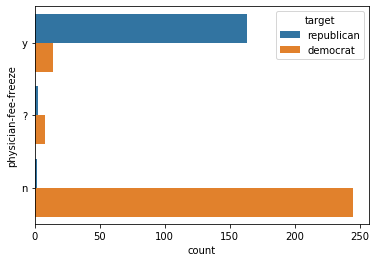

In [0]:
sns.countplot(y = 'physician-fee-freeze', data = vote_df, hue = 'target')

In [0]:
labels = km.fit_predict(vote_df)

In [0]:
sum(labels == [0 if e == "republican" else 1 for e in vote_df.target]) / len(labels)

0.8758620689655172

#Zadanie 4. (2 punkty)
Zdjęcie fotograficzne o rozdzielczości A x B w formacie RGB można traktować jako zbiór N = A * B trójwymiarowych punktów danych. Po przeprowadzeniu grupowania takich danych, z liczbą grup K, można obniżyć liczbę kolorów zdjęcia do K (tworząc paletę K kolorów określonych przez środki uzyskanych grup, a następnie zastępując kolor każdego piksela najbliższym mu kolorem ze stworzonej palety). Napisz program wczytujący zdjęcie z pliku JPG (polecenie imread w Matlabie lub w Pythonie), redukujący liczbę kolorów w powyższy sposób i wyświetlający zredukowane zdjęcie na ekranie. Sprawdź działanie programu na 5 wybranych przez siebie zdjęciach.

(zrobiony lokalnie w jupyterze)

#Zadanie 5. (2 punkty)
Zbiór danych Kosarak (stworzony przez Ferenca Bodona, dostępny m.in. na
http://fimi.ua.ac.be/data/kosarak.dat.gz) zawiera informacje o transakcjach zawartych w sieci supermarketów. Każdy wiersz tego pliku reprezentuje jedną transakcję i zawiera identyfikatory produktów kupionych w tej transakcji.



In [0]:
prods_df = pd.read_csv("http://fimi.ua.ac.be/data/kosarak.dat.gz",header = None)

In [0]:
N = prods_df.shape[0]
Products = {}
for i in range(N):
    for prod in prods_df[0].loc[i].split(' '):
        Products[int(prod)] = Products.get(int(prod),0) + 1

In [0]:
K = len(Products)

In [0]:
T = 1000
Most_often_bought = [(p,l) for p,l in Products.items()]
Most_often_bought.sort(key = lambda x: x[1], reverse = True)
Most_often_bought = Most_often_bought[:T]
Most_often_bought = [p for (p,a) in Most_often_bought]

In [0]:
index = {}
for i,e in enumerate(Most_often_bought):
    index[e] = i

In [0]:
Most_often_bought_set = set(Most_often_bought)

In [0]:
prods_matrix = np.zeros([T,K])

In [0]:
for i in tqdm.tqdm(range(N)):
    line = prods_df[0].loc[i].split(' ')
    for i in range(len(line)):
        for j in range(i+1,len(line)):
            if int(line[j]) in Most_often_bought_set:
                prods_matrix[index[int(line[j])]][int(line[i])-1] += 1

100%|██████████| 990002/990002 [05:21<00:00, 3081.94it/s]


In [0]:
prods_matrix = prods_matrix.astype(np.int)

In [0]:
K = 50
d = 1000
G,R = K_means(prods_matrix,K,50)

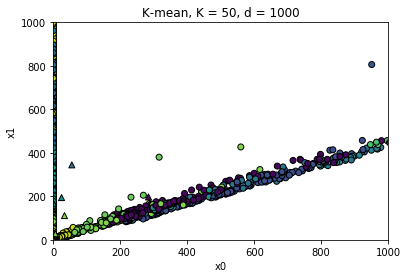

In [0]:
plot(prods_matrix,G,R,K,d)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.show()

##a) 
Wyznacz T = 1000 najczęściej kupowanych produktów (tzn. produktów, które pojawiły się w największej liczbie transakcji). Oznaczmy je kolejno Z1, Z2, …, ZT.

##b) 
Dla każdego produktu, policz ile razy był on kupowany razem z produktem Zi (dla i =1, 2, …, T) tworząc w ten sposób wektor liczbowy p = (p1, p2, …, pT) opisujący dany produkt.


##c) 
Pogrupuj produkty używając ich powyższej reprezentacji oraz algorytmu K-Means z różną liczbą grup (poeksperymentuj).

Przedstaw wyniki swoich eksperymentów. Możesz także poeksperymentować z parametrem T.
Które grupy produktów można uznać za szczególnie istotne, a które za raczej przypadkowe? 